In [1]:
PRFX = 'DevAdvVal0808_1'
p_o = '../output/{PRFX}'

In [11]:
BS = 16
SZ = 456

FP16 = True

DBG = False

In [3]:
# Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.cache/torch/checkpoints/efficientnet-b3-c8376fa2.pth
import os
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')

!cp ../input/efficientnetpytorch/*.pth /tmp/.cache/torch/checkpoints/

In [4]:
!pip install ../input/efficientnetpytorch/efficientnet_pytorch-0.3.0-py3-none-any.whl

# data

In [5]:
from fastai.vision import *

In [6]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
train_diab = pd.read_csv('../input/diabetic-retinopathy-resized//trainLabels.csv')

In [7]:
train.shape, test.shape, train_diab.shape

((3662, 2), (1928, 1), (35126, 2))

In [8]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)
img2grd_blnd_train = [(f'{pp}/train_images/{o[0]}.png',1)  for o in train.values]
img2grd_blnd_test  = [(f'{pp}/test_images/{o[0]}.png', 1)  for o in test.values]
p = '../input/diabetic-retinopathy-resized/resized_train/'
pp = Path(p)
img2grd_diab  = [(f'{pp}/{o[0]}.jpeg', 0)  for o in train_diab.values]

img2grd = img2grd_blnd_train+img2grd_blnd_test+img2grd_diab
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

40716

[(0, 35126), (1, 5590)]

In [9]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [10]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

In [12]:
if DBG:
    df = df.sample(2000)

In [13]:
df.shape

(40716, 2)

In [14]:
df.target.value_counts()

0    35126
1     5590
Name: target, dtype: int64

In [15]:
df.sample(5)

,fnm,target
18129,../input/diabetic-retinopathy-resized/resized_...,0
27049,../input/diabetic-retinopathy-resized/resized_...,0
72,../input/aptos2019-blindness-detection/train_i...,1
12180,../input/diabetic-retinopathy-resized/resized_...,0
1177,../input/aptos2019-blindness-detection/train_i...,1


In [16]:
%%time
tfms = []

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_none()
            .label_from_df(cols='target')
          )

    data= (src.transform(tfms, size=sz) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data


bs = BS 
sz = SZ
data = get_data(sz, bs)

CPU times: user 2.26 s, sys: 365 ms, total: 2.63 s
Wall time: 1.91 s


CPU times: user 3.97 s, sys: 1.44 s, total: 5.42 s
Wall time: 7.21 s


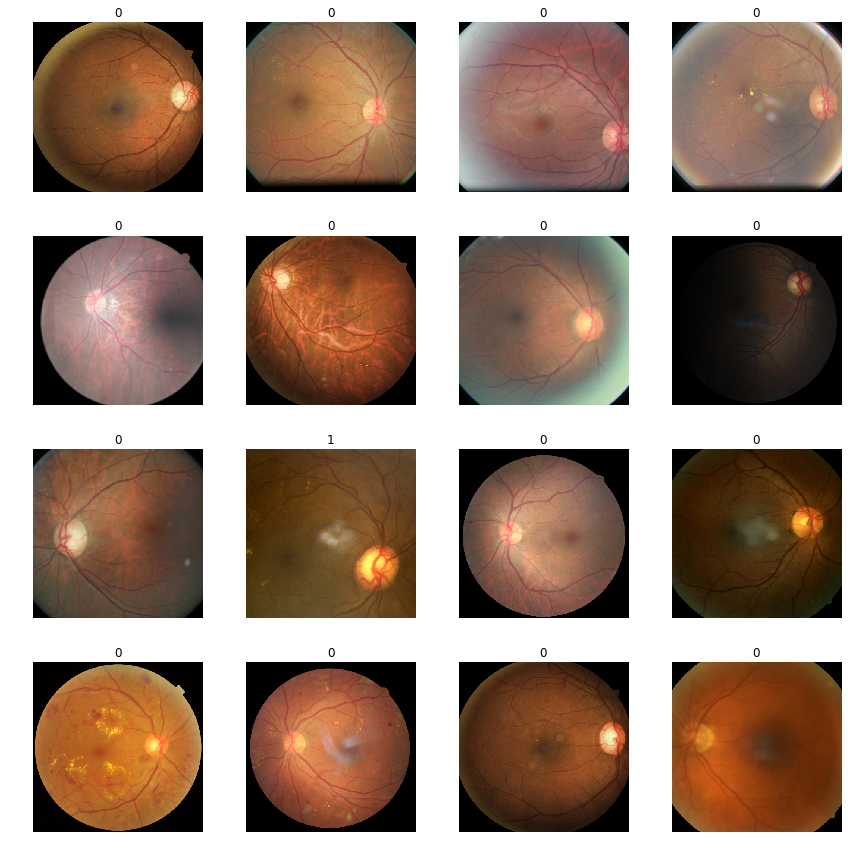

In [17]:
%%time
data.show_batch(rows=4, figsize=(12,12))

# model

In [18]:
from efficientnet_pytorch import EfficientNet

MODEL_NAME = 'efficientnet-b5'
model = EfficientNet.from_pretrained(MODEL_NAME, num_classes=2) 
learn = Learner(data, model, path=p_o, 
#                 wd=WD,  
#                 metrics=[accuracy, qwk],
               )

if FP16: learn = learn.to_fp16()

Loaded pretrained weights for efficientnet-b5


In [ ]:
%%time
learn.lr_find(start_lr=1e-5)

In [19]:
!nvidia-smi

Thu Aug  8 15:24:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   59C    P0    46W / 300W |   1107MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.013992,#na#,19:57
1,0.000002,#na#,20:01


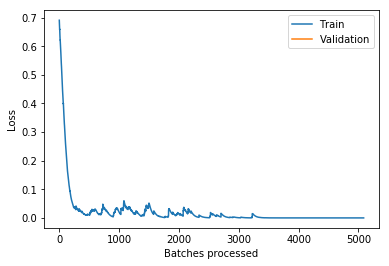

In [21]:
learn.recorder.plot_losses()

In [22]:
learn.save('mdl')

In [23]:
!nvidia-smi

Thu Aug  8 16:06:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   71C    P0    65W / 300W |  15417MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# prediction

In [24]:
preds, y = learn.get_preds(ds_type=DatasetType.Fix)

In [25]:
preds = preds.numpy().squeeze()
y = y.numpy()

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, preds[:,1])

0.9999999745358316

In [27]:
df.shape, y.shape, (df.target==y).mean()

((40716, 2), (40716,), 1.0)

In [28]:
np.save(f'{p_o}/preds.npy', preds)
np.save(f'{p_o}/y.npy', y)

In [29]:
imgs = learn.data.train_ds.x.items
np.save(f'{p_o}/imgs.npy', imgs)

# use result

In [30]:
preds.shape

(40716, 2)

In [31]:
scrs = preds[:,1]

In [32]:
idx_sorted = np.argsort(-scrs)
idx_sorted

array([ 4528,     0,  3740,  3739, ..., 33498, 27023, 35315, 10634])

In [33]:
idx_old = set(np.where(y==0)[0])
idx_new = set(np.where(y==1)[0])

In [34]:
idx_sorted_old = np.array([o for o in idx_sorted if o in idx_old])
idx_sorted_new = np.array([o for o in idx_sorted if o in idx_new])
len(idx_sorted_old), idx_sorted_old

(35126, array([15100,  6130, 31190, 19806, ..., 33498, 27023, 35315, 10634]))

In [35]:
scrs[idx_sorted_new[:5]]

array([1., 1., 1., 1., 1.], dtype=float32)

In [36]:
scrs[idx_sorted_old[:5]]

array([0.98302 , 0.637539, 0.022138, 0.017259, 0.004248], dtype=float32)

In [37]:
scrs[idx_sorted_new[-5:]]

array([0.999996, 0.999985, 0.999954, 0.999897, 0.002364], dtype=float32)

In [38]:
scrs[idx_sorted_old[-5:]]

array([1.711863e-23, 1.122667e-23, 8.213607e-24, 2.584526e-24, 4.089314e-25], dtype=float32)

In [39]:
imgs[idx_sorted_old[5:]]

array(['./../input/diabetic-retinopathy-resized/resized_train/40836_right.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/33555_right.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/15018_right.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/662_right.jpeg', ...,
       './../input/diabetic-retinopathy-resized/resized_train/35343_left.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/27004_right.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/37602_right.jpeg',
       './../input/diabetic-retinopathy-resized/resized_train/6367_left.jpeg'], dtype='<U71')

In [40]:
from PIL import Image as PImage
nsmpl=5
def show_imgs(idx):
    fig, axes = plt.subplots(1, nsmpl, figsize=(15,15))
    for i,ind in enumerate(idx):
        ax = axes[i]
        im = PImage.open(imgs[ind])
        im.thumbnail((128,128), PImage.ANTIALIAS)
        ax.set_title(scrs[ind])
        ax.imshow(im)
        ax.axis('off')

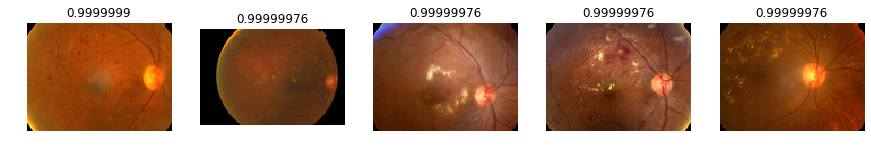

In [43]:
idx = idx_sorted_new[:nsmpl]
show_imgs(idx)

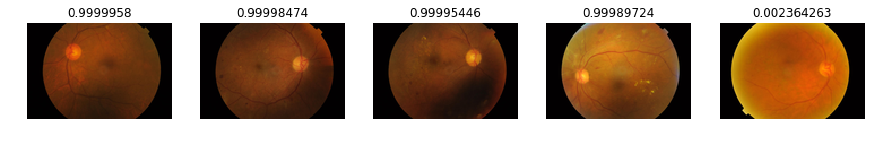

In [44]:
idx = idx_sorted_new[-nsmpl:]
show_imgs(idx)

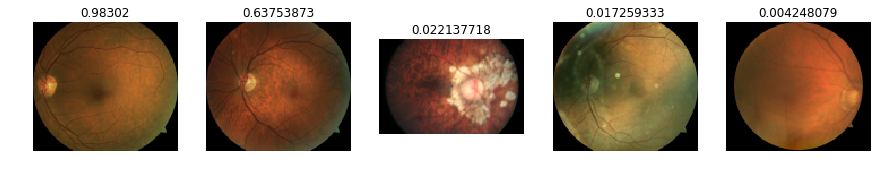

In [41]:
idx = idx_sorted_old[:nsmpl]
show_imgs(idx)

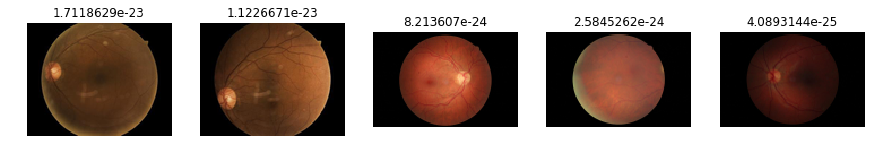

In [42]:
idx = idx_sorted_old[-nsmpl:]
show_imgs(idx)